In [1]:
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn.objects as so

from sklearn.cluster import KMeans

## Clustering

**Ejercicio 1**

In [2]:
df_news = pd.read_csv("noticias.csv")

**Ejercicio 2**

In [3]:
df_sports = df_news[df_news["category"]=='sport']
df_sports.head()

,title,content,category
1313,Claxton hunting first major medal,British hurdler Sarah Claxton is confident she...,sport
1314,O'Sullivan could run in Worlds,Sonia O'Sullivan has indicated that she would ...,sport
1315,Greene sets sights on world title,Maurice Greene aims to wipe out the pain of lo...,sport
1316,IAAF launches fight against drugs,The IAAF - athletics' world governing body - h...,sport
1317,"Dibaba breaks 5,000m world record",Ethiopia's Tirunesh Dibaba set a new world rec...,sport


**Ejercicio 3**

In [4]:
nltk.download("stopwords")
nltk.download('punkt_tab')

stop_words = set(stopwords.words("english"))
stemmer = SnowballStemmer(language="english")

# Generamos una lista con todos los stems de palabras del texto
# (excluyendo stop words y palabras que tienen numeros o simbolos)
def tokenize_and_stem(text):
    tokens = word_tokenize(text.lower())
    stems = [stemmer.stem(token) for token in tokens if
    (token.isalpha() and token not in stop_words)]
    return stems

vectorizer = CountVectorizer(analyzer=tokenize_and_stem)
X = vectorizer.fit_transform(df_sports["content"])
df_sports_stems = pd.DataFrame(X.toarray(),
columns=vectorizer.get_feature_names_out())


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/cristiann/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/cristiann/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


**Ejercicio 4**

In [5]:
# Calculamos componentes principales manualmente
"""
X_star = df_sports_stems - df_sports_stems.mean() # Normalizamos a media 0
X_star_t = np.transpose(X_star)
N = len(X_star)

Sigma = (X_star_t @ X_star) / N  # Matriz de covarianza

# Esta celda sin comentar es bastante pesada
autovalores, U =  np.linalg.eigh(Sigma)

# Damos vuelta orden de ambos y signo del segundo autovector para que quede igual que con PCA de sklearn 
autovalores = np.flip(autovalores)
U = np.flip(U, 1)
U[:, 1] *= -1

Z = X_star @ U
"""

'\nX_star = df_sports_stems - df_sports_stems.mean() # Normalizamos a media 0\nX_star_t = np.transpose(X_star)\nN = len(X_star)\n\nSigma = (X_star_t @ X_star) / N  # Matriz de covarianza\n\n# Esta celda sin comentar es bastante pesada\nautovalores, U =  np.linalg.eigh(Sigma)\n\n# Damos vuelta orden de ambos y signo del segundo autovector para que quede igual que con PCA de sklearn \nautovalores = np.flip(autovalores)\nU = np.flip(U, 1)\nU[:, 1] *= -1\n\nZ = X_star @ U\n'

In [6]:
# Calculamos componentes principales con PCA de sklearn

n=len(df_sports_stems)

pca = PCA(n_components=n)
Z = pd.DataFrame(pca.fit_transform(df_sports_stems))
autovalores = pca.explained_variance_

In [7]:
Z.columns = ["Z" + str(i) for i in range(1, len(Z.columns) + 1)] # Renombramos las columnas

Text(0.5, 1.0, 'Proyección en 2 Componentes principales con el Método bag-of-words"')

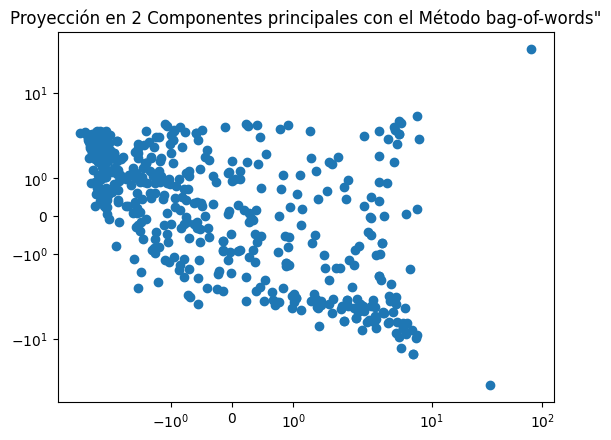

In [8]:
# Grafico en 2 PCA

plt.scatter(Z.Z1, Z.Z2)
plt.xscale('symlog') # log pero sin eliminar valores <= 0
plt.yscale('symlog')
plt.title('Proyección en 2 Componentes principales con el Método bag-of-words"')

**Ejercicio 5**
Notamos que los valores se acumulan en un unico Cluster, exceptuando 2 outsiders que obligan a ver el grafico en escala logaritmica. Esto significa que 2 autovalores no nos alcanzaron para diferenciar categorias. Al no ponderar entre palabras comunes y palabras raras, al metodo le cuesta contextualizar a la noticia y marcar su relacion (cercana o lejana) con otras

In [9]:
# Varianza explicada por los últimos n autovalores
nComps = 2
print(autovalores[:nComps].sum() / sum(autovalores))

0.09975786971534387


Los primeros 2 autovalores solo explican el 10% de la varianza, lo que hace natural que no podamos diferenciar grupos en la proyección grafica

**Ejercicio 6**

In [10]:
# Text vectorization using TF -IDF
vectorizer = TfidfVectorizer(analyzer=tokenize_and_stem ,
smooth_idf = False)
X = vectorizer.fit_transform(df_sports["content"])
df_sports_tfidf = pd.DataFrame(X.toarray (),
columns=vectorizer.get_feature_names_out ())

In [11]:
# Calculamos componentes principales con PCA de sklearn

n=2

pca = PCA(n_components=n)
Z = pd.DataFrame(pca.fit_transform(df_sports_tfidf))
Z.columns = ["Z" + str(i) for i in range(1,n+1)]  # Renombramos las columnas

**Ejercicio O1...**

**Ejercicio 7**

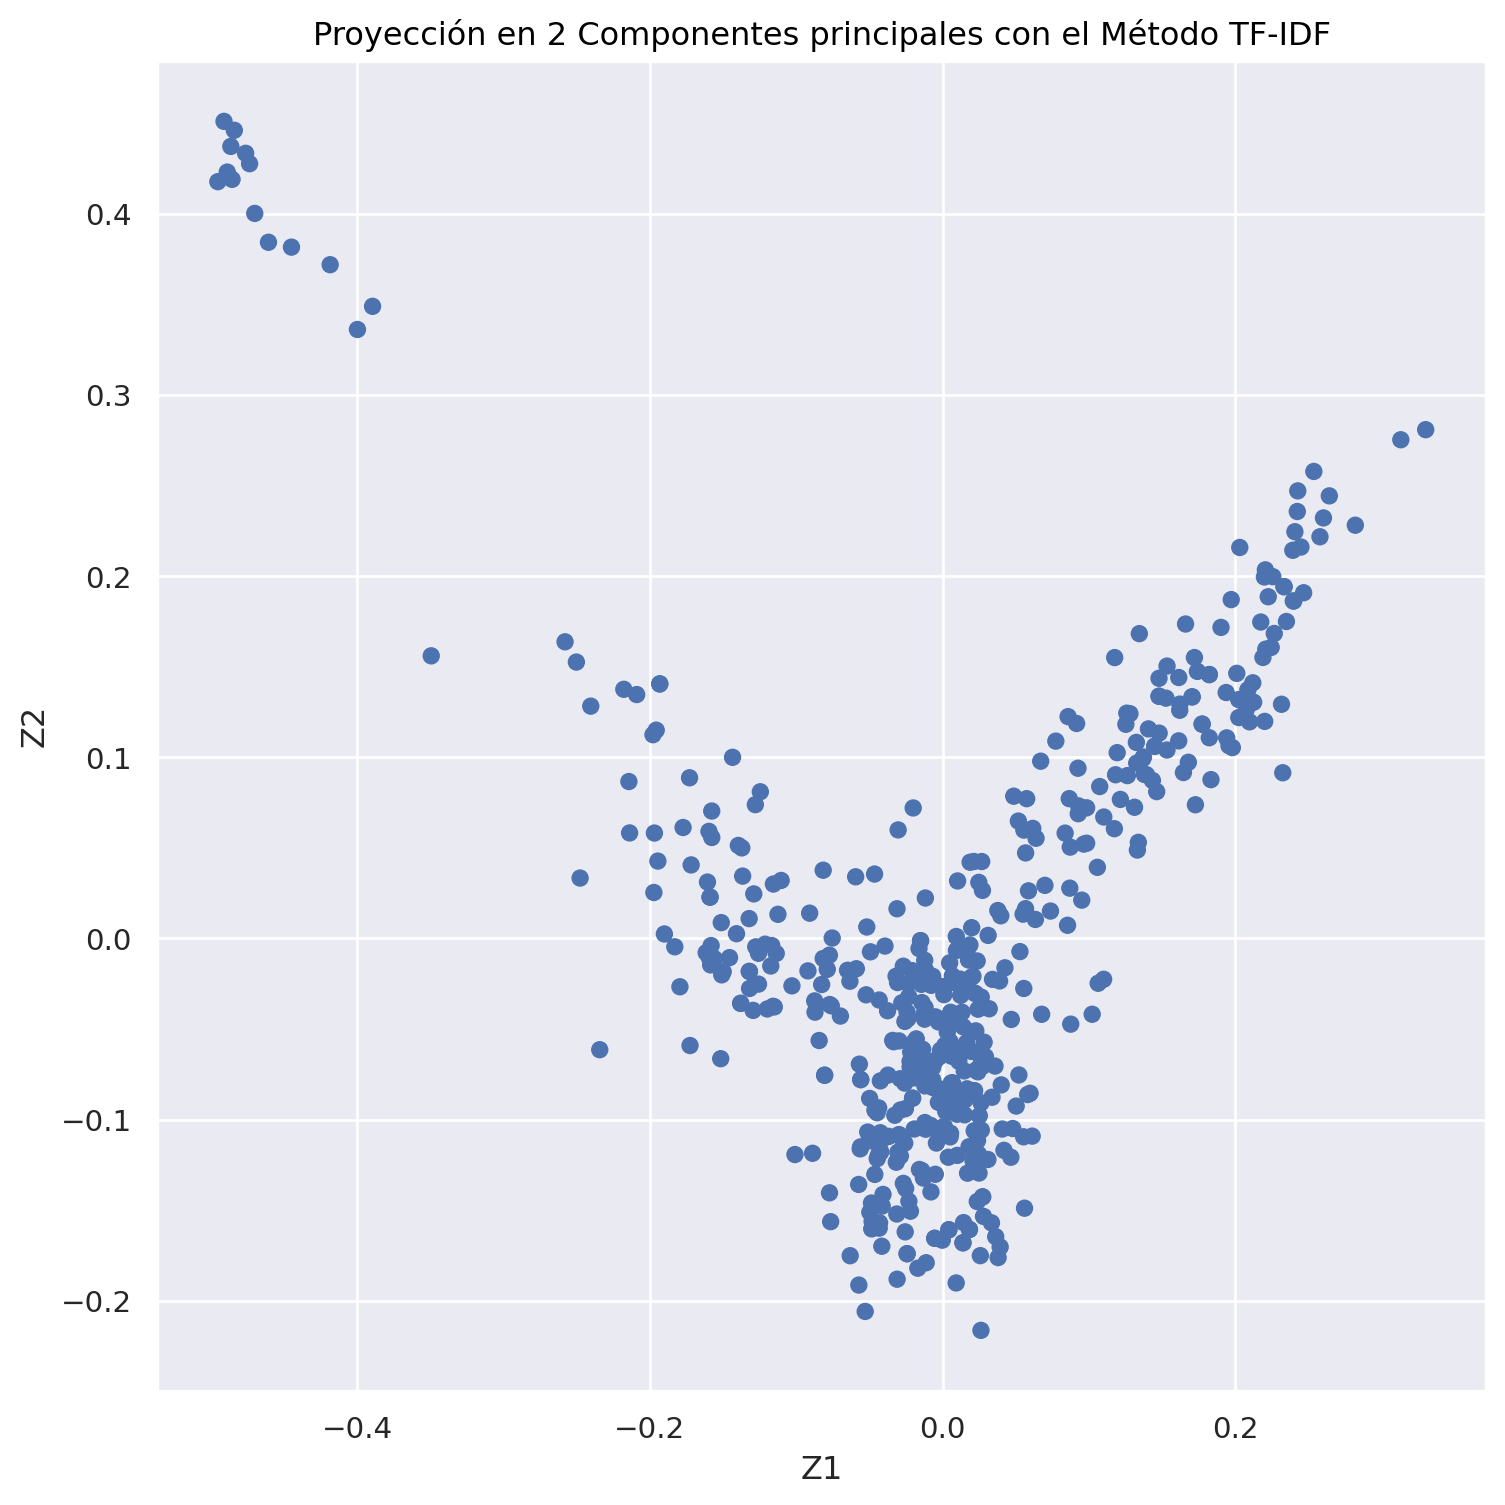

In [12]:
(
    so.Plot(Z, x="Z1", y="Z2")
    .add(so.Dot())
    .add(so.Text(valign="bottom"))
    .label(title="Proyección en 2 Componentes principales con el Método TF-IDF")
    .layout(size=(8,8))   # Conviene graficar en un cuadrado para ver correctamente las distancias 
)

Si bien no parece que los posibles clusters vayan a tener una forma esferica y isotropica, notamos que simultaneamente hay un grupo central muy denso y otros grupos perifericos poco densos, por lo que DBSCAN no podria separar los clusters. Entonces, probemos con Kmeans

**Ejercicio 8**

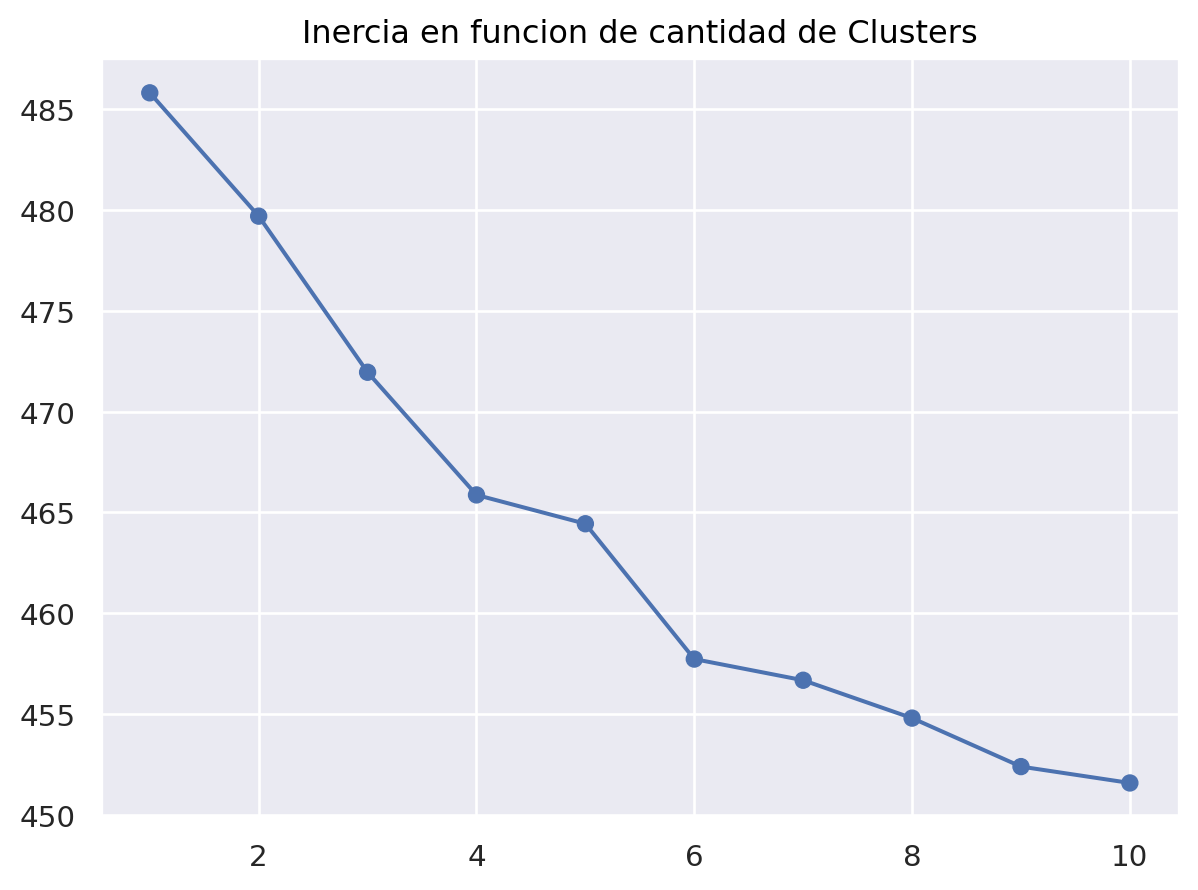

In [13]:
# Elección de la Cantidad de Clusters usando el método del Codo

inertias = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(df_sports_tfidf)
    inertias.append(kmeans.inertia_)

# Graficar el método del codo
(
    so.Plot(x = k_values, y = inertias)
    .add(so.Line())
    .add(so.Dot())
    .label(title="Inercia en funcion de cantidad de Clusters")
)

Por los cambios de pendiente del Gráfico, el método nos da al 4 o al 6 como posibles candidatos a la cantidad de Clusters

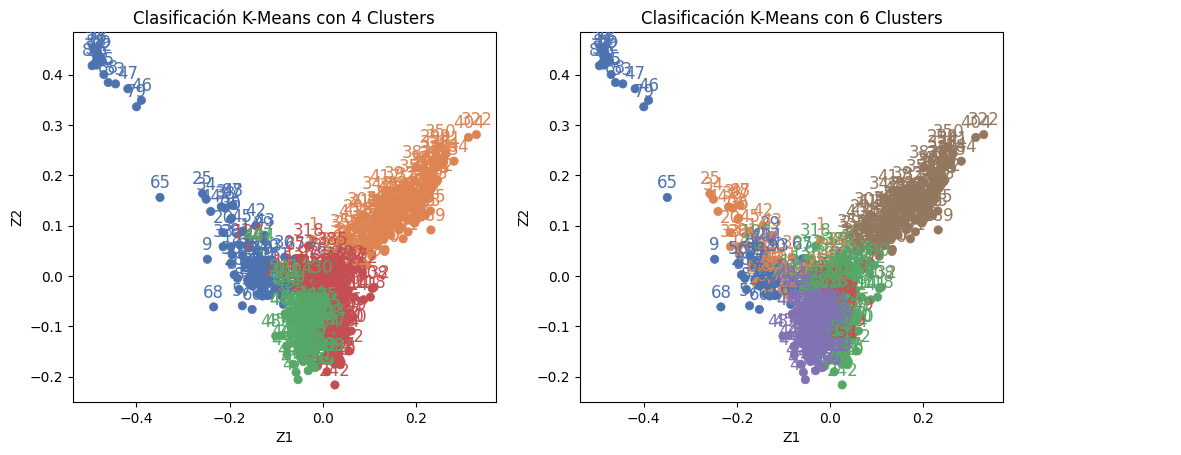

In [14]:
fig, ax = plt.subplots(1,2)  # Utilizamos este código para crear una grilla de dos gráficos.
fig.set_figwidth(12)

# KMeans con 4 Clusters
kmeans = KMeans(n_clusters=4, random_state=42)
etiquetas4 = kmeans.fit_predict(df_sports_tfidf)
(
    so.Plot(Z, x="Z1", y="Z2", color = etiquetas4.astype("str"), text=Z.index)
    .add(so.Dot())
    .add(so.Text(valign="bottom"))
    .label(title="Clasificación K-Means con 4 Clusters")
                                .on(ax[0]).plot()  # Primera casilla de la grilla.
)

# KMeans con 6 Clusters
kmeans = KMeans(n_clusters=6, random_state=42)
etiquetas6 = kmeans.fit_predict(df_sports_tfidf)
(
    so.Plot(Z, x="Z1", y="Z2", color = etiquetas6.astype("str"), text=Z.index)
    .add(so.Dot())
    .add(so.Text(valign="bottom"))
    .label(title="Clasificación K-Means con 6 Clusters")
                                .on(ax[1]).plot()  # Segunda casilla de la grilla.
)

plt.show()

**Ejercicio 9**
Comparandolo con el de 4 Clusters, lo que hace la division en 6 es separar el Cluster de la rama que va hacia Z1 negativo y también separar unos pocos elementos del que esta alrededor del 0,0. Al menos viendolo desde el grafico de la proyección en las 2 Componentes Principales, no parece que ninguna de estas separaciones vaya a ser significativamente distinta a su Cluster original, asi que nos quedamos con el de 4.

Exceptuando unos pocos casos aislados en dicha rama en Z1 negativo, los elementos en la separacion en 4 Clusters quedan cerca entre si y son casi perfectamente disjuntos en la proyección de 2 Componentes Principales

**Ejercicio 10**
Vamos a acercar un poco el grafico a cada Cluster para poder leer mejor los indices

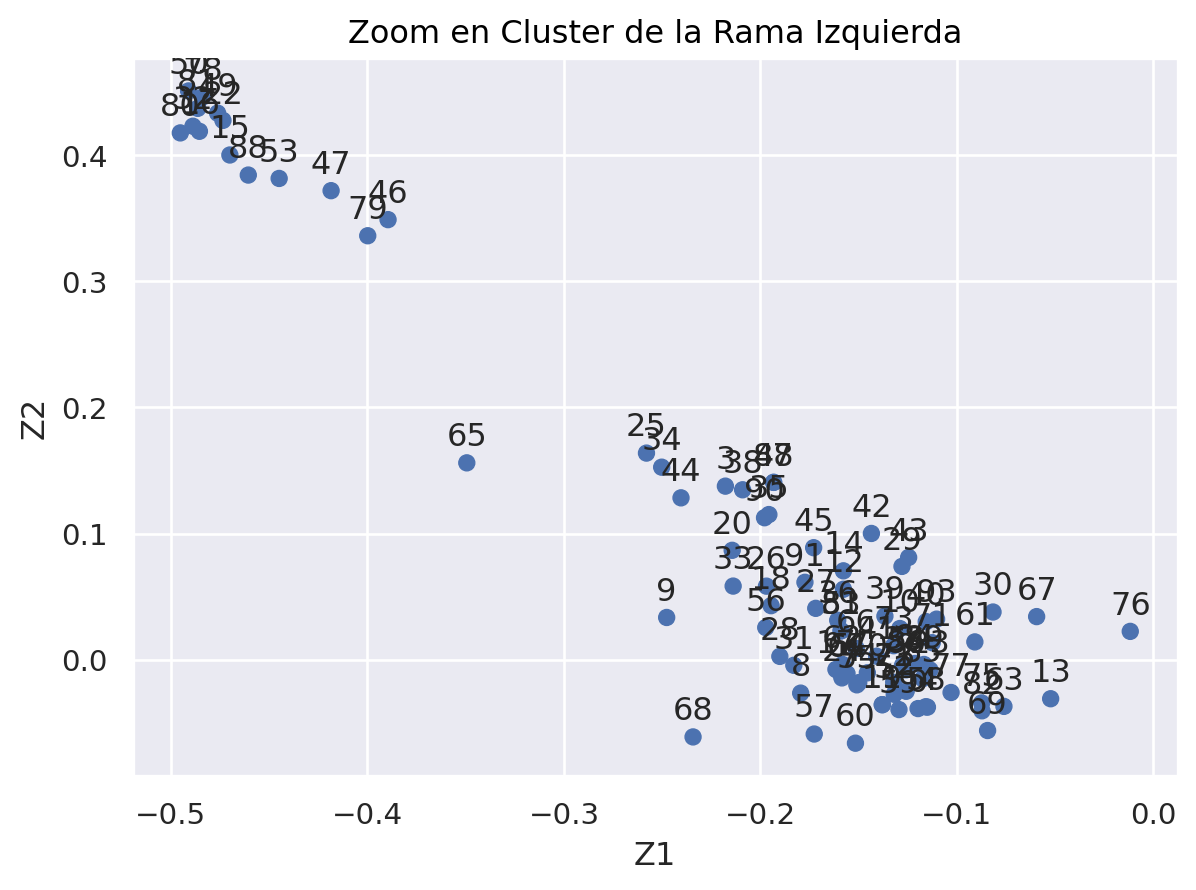

In [15]:
# Cluster que va hacia Z1 negativo & Z2 positivo

ZramaIzq = Z[(etiquetas4==2)]
(
so.Plot(ZramaIzq, x="Z1", y="Z2", text=ZramaIzq.index)
.add(so.Dot())
.add(so.Text(valign="bottom"))
.label(title="Zoom en Cluster de la Rama Izquierda")
)

In [41]:
# Vemos el contenido de algunas
print("Rama izquierda")
display(df_sports.iloc[9:10])
display(df_sports.iloc[25:26])
display(df_sports.iloc[42:43])
display(df_sports.iloc[46:48])
display(df_sports.iloc[65:66])
display(df_sports.iloc[68]["content"])
display(df_sports.iloc[76]["content"])
display(df_sports.iloc[88:89])

print(etiquetas6[25]==etiquetas6[198])


Rama izquierda


,title,content,category
1322,Collins to compete in Birmingham,World and Commonwealth 100m champion Kim Colli...,sport


,title,content,category
1338,Collins appeals against drugs ban,Sprinter Michelle Collins has lodged an appeal...,sport


,title,content,category
1355,Collins named UK Athletics chief,UK Athletics has ended its search for a new pe...,sport


,title,content,category
1359,Kenteris denies faking road crash,Greek sprinter Kostas Kenteris has denied clai...,sport
1360,Greek pair set for hearing,Kostas Kenteris and Katerina Thanou will fight...,sport


,title,content,category
1378,Britain boosted by Holmes double,Athletics fans endured a year of mixed emotion...,sport


'Double Olympic champion Kelly Holmes was back to her best as she comfortably won the 1,000m at the Norwich Union Birmingham Indoor Grand Prix.\n \n The 34-year-old, running only her second competitive race of the season, shook off the rust to win in two minutes, 35.39 seconds. But she is still undecided about competing in the European Championships in Madrid from 4-6 March. "I\'ll probably be entered and make my mind up at the last minute," she said. "My training hasn\'t gone as well as expected but I\'ve got two weeks to decide. "I need to take my time and make sure I feel good about what I\'m doing. "I felt very good here but with the crowd behind you, you feel like you can do anything." American\n \n was the eventual winner of the men\'s 60m race which almost ended in farce. Three athletes were disqualified for false starting, including Britain\'s Mark Lewis-Francis, who was the first man guilty of coming out of his blocks too quickly. World 100m champion Kim Collins clinched secon

"European cross-country champion Hayley Yelling completed a hat-trick of wins in the Reebok Cardiff Cross Challenge in Bute Park on Sunday afternoon.\n \n The part-time maths teacher beat Irish international Jolene Byrne by 40 metres in the six-kilometre race. Another Great Britain international, Louise Damen, finished third as part of the contingent representing England. Peter Riley, who secured bronze for the GB men's team at last month's European Championships, won the men's 9km race. Riley, representing England, moved away over the last two kilometres to win by 25 metres from Ireland's Gary Murray. Glynn Tromans - the reigning UK Inter-Countries and England Cross-Country champion - came in third place as he continues his comeback from a five-month injury lay-off.\n"

,title,content,category
1401,Thanou desperate to make return,Greek sprinter Katerina Thanou says she is eag...,sport


False


Son todas noticias de atletismo. También confirmamos que quedarse con 4 Clusters fue la decision correcta, con 6 Clusters tendriamos 2 separados pero con una misma tematica

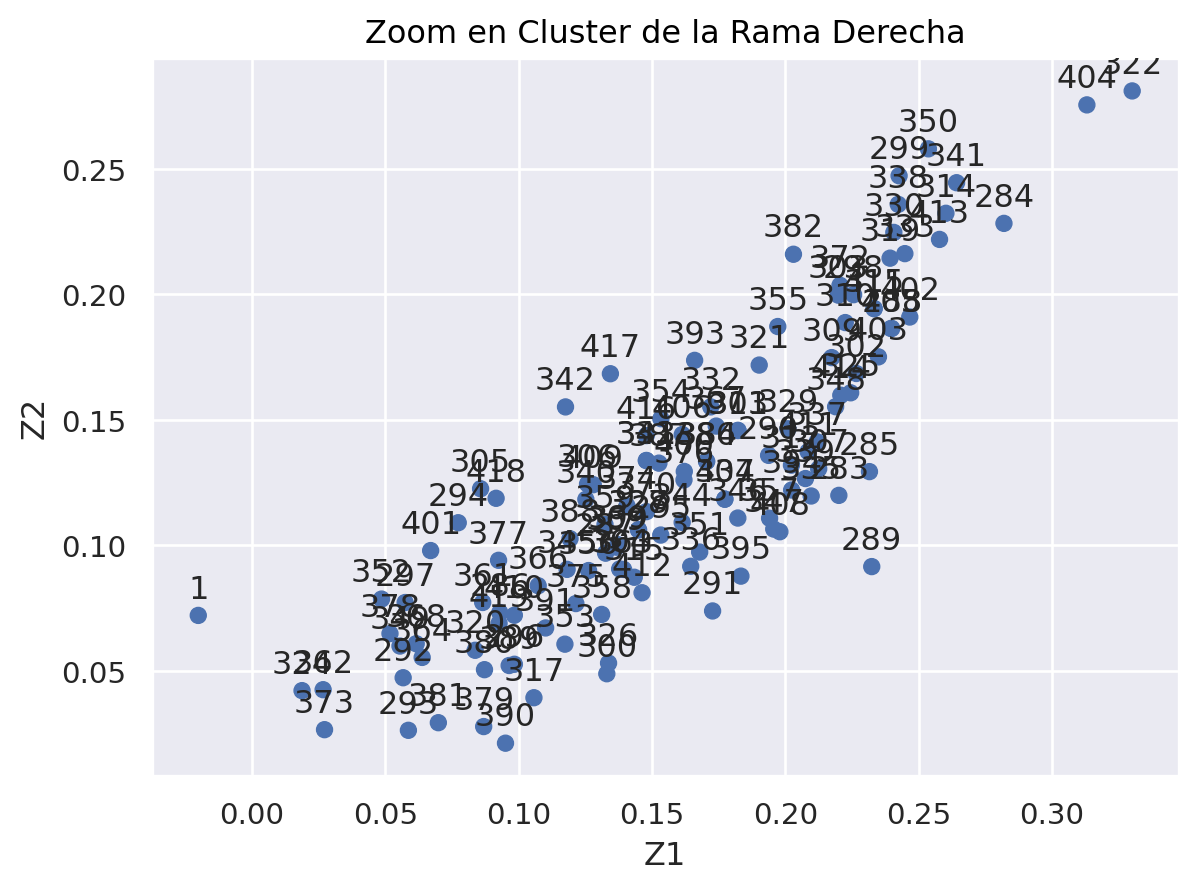

In [17]:
# Cluster que va hacia Z1 positivo & Z2 positivo

ZramaDer = Z[(etiquetas4==1)]
(
so.Plot(ZramaDer, x="Z1", y="Z2", text=ZramaDer.index)
.add(so.Dot())
.add(so.Text(valign="bottom"))
.label(title="Zoom en Cluster de la Rama Derecha")
)


In [52]:
print("Rama derecha")
display(df_sports.iloc[1]["content"])
display(df_sports.iloc[283:286])
display(df_sports.iloc[284]["content"])
display(df_sports.iloc[291:293])
display(df_sports.iloc[309:311])
display(df_sports.iloc[314:315])
display(df_sports.iloc[322:323])
display(df_sports.iloc[404:405])

Rama derecha


"Sonia O'Sullivan has indicated that she would like to participate in next month's World Cross Country Championships in St Etienne.\n \n Athletics Ireland have hinted that the 35-year-old Cobh runner may be included in the official line-up for the event in France on 19-20 March. Provincial teams were selected after last Saturday's Nationals in Santry and will be officially announced this week. O'Sullivan is at present preparing for the London marathon on 17 April. The participation of O'Sullivan, currentily training at her base in Australia, would boost the Ireland team who won the bronze three years agio. The first three at Santry last Saturday, Jolene Byrne, Maria McCambridge and Fionnualla Britton, are automatic selections and will most likely form part of the long-course team. O'Sullivan will also take part in the Bupa Great Ireland Run on 9 April in Dublin.\n"

,title,content,category
1596,Hodgson shoulders England blame,Fly-half Charlie Hodgson admitted his wayward ...,sport
1597,Vickery out of Six Nations,England tight-head prop Phil Vickery has been ...,sport
1598,Yachvili savours France comeback,France scrum-half Dimitri Yachvili praised his...,sport


'England tight-head prop Phil Vickery has been ruled out of the rest of the 2005 RBS Six Nations after breaking a bone in his right forearm.\n \n Vickery was injured as his club side, Gloucester, beat Bath 17-16 in the West country derby on Saturday. He could be joined on the sidelines by Bath centre Olly Barkley, who sat out the derby due to a leg injury. Barkley will have a scan on Sunday and might miss England\'s trip to Six Nations leaders Ireland next weekend. The news is just the latest blow for coach Andy Robinson, who has seen his side lose their opening two matches in the 2005 Six Nations. Robinson is already without World Cup winners Jonny Wilkinson, Will Greenwood, Mike Tindall, Richard Hill and Trevor Woodman through injury. Vickery has broken the radius, a large bone in his forearm. He only returned to the England side last weekend after a long-term back injury, which was followed by a fractured eye socket. And the Gloucester prop was only recalled after Leicester tight-he

,title,content,category
1604,Wales coach elated with win,Mike Ruddock paid tribute to his Wales side af...,sport
1605,Newcastle 27-27 Gloucester,Newcastle centre Mathew Tait answered his crit...,sport


,title,content,category
1622,Wales make two changes for France,Wales coach Mike Ruddock has made two changes ...,sport
1623,Ireland surge past Scots,Ireland maintained their Six Nations Grand Sla...,sport


,title,content,category
1627,Barkley fit for match in Ireland,England centre Olly Barkley has been passed fi...,sport


,title,content,category
1635,Preview: Ireland v England (Sun),"Lansdowne Road, Dublin\n \n Sunday, 27 Februar...",sport


,title,content,category
1717,Ireland 19-13 England,Ireland consigned England to their third strai...,sport


Las noticias cuentan sobre enfrentamientos de Selecciones en la RBS Six Nations. Leyendo el contenido de la noticia numero 1, notamos que deberia estar en el anterior Cluster por escribir sobre el atletismo. Se puede haber filtrado por nombrar a paises que participan en el evento del Cluster actual. Tambien notamos que las palabras relacionadas al atletismo hicieron que en la proyeccion, el punto 1 se encuentre en una "zona de frontera" entre la rama izquierda y derecha

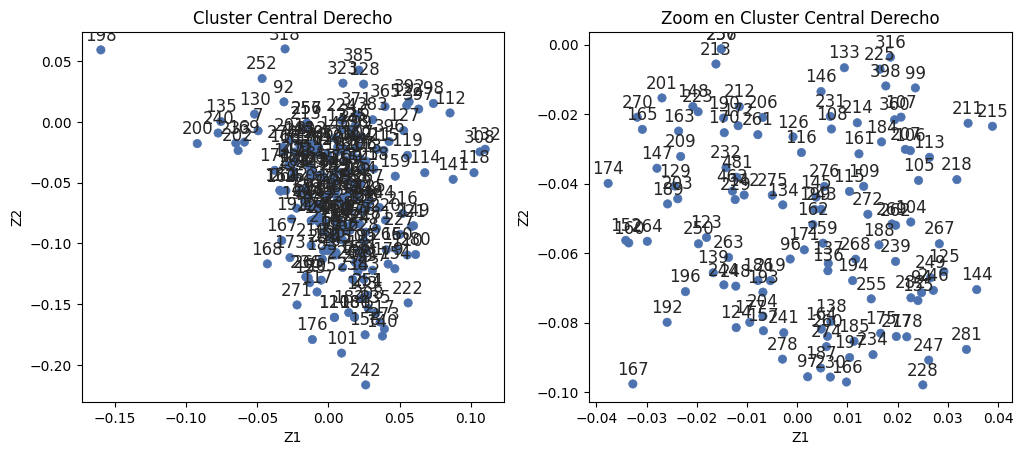

In [19]:
# Cluster Central Derecho

ZCentroDer = Z[(etiquetas4==0)]

ZCentroZoom = ZCentroDer[
    (ZCentroDer["Z2"] < 0) & (ZCentroDer["Z2"] > -0.1) & 
    (ZCentroDer["Z1"] > -0.04) & (ZCentroDer["Z1"] < 0.04)
]


fig, ax =plt.subplots(1,2)  # Otra vez, grilla de 2 graficos
fig.set_figwidth(12)


(
    so.Plot(ZCentroDer, x="Z1", y="Z2", text=ZCentroDer.index)
    .add(so.Dot())
    .add(so.Text(valign="bottom"))
    .label(title="Cluster Central Derecho")
                                .on(ax[0]).plot()
)


(
    so.Plot(ZCentroZoom, x="Z1", y="Z2", text=ZCentroZoom.index)
    .add(so.Dot())
    .add(so.Text(valign="bottom"))
    .label(title="Zoom en Cluster Central Derecho")
                                .on(ax[1]).plot()
)

plt.show()

In [35]:
print("Cluster centro lado Derecho")
display(df_sports.iloc[141]["content"])
display(df_sports.iloc[168:169])
display(df_sports.iloc[198]["content"])
display(df_sports.iloc[318:319])
display(df_sports.iloc[385]["content"])
print("Estas se ven en el Zoom")
display(df_sports.iloc[96:98])
display(df_sports.iloc[192:193])
display(df_sports.iloc[222:223])
display(df_sports.iloc[241:242])
display(df_sports.iloc[398]["content"])
display(df_sports.iloc[481:482])

Cluster centro lado Derecho


'England forward Michael Owen has told the BBC he is happy in Spain and has no plans to quit Real Madrid to return to the Premiership in the near future.\n \n But the 25-year-old, who has spent much of his time coming off the bench in La Liga, did not rule out a return to the Premiership at some stage. "I\'m pleased with the start I\'ve made here," he told BBC Radio Five Live. "England is my country. It\'s definitely part of me but who knows whether, if or when I\'ll be playing there again." Owen, who moved to the Bernabeu from Liverpool last summer, has grabbed 11 goals for Real but has been unable to replace Raul or Ronaldo in the starting line-up. However, he said he was delighted with the way his time in Spain was going and dismissed criticism of his decision to join Real. "When I first came there was a lot of scepticism back in England, any maybe some out here," he said. "People were saying \'fourth-choice striker, what are you going there for? You\'ll be sat on the bench all the 

,title,content,category
1481,FA decides not to punish Mourinho,The Football Association will take no action a...,sport


'Chelsea have sacked Adrian Mutu after he failed a drugs test.\n \n The 25-year-old tested positive for a banned substance - which he later denied was cocaine - in October. Chelsea have decided to write off a possible transfer fee for Mutu, a £15.8m signing from Parma last season, who may face a two-year suspension. A statement from Chelsea explaining the decision read:"We want to make clear that Chelsea has a zero tolerance policy towards drugs." Mutu scored six goals in his first five games after arriving at Stamford Bridge but his form went into decline and he was frozen out by coach Jose Mourinho. Chelsea\'s statement added: "This applies to both performance-enhancing drugs or so-called \'recreational\' drugs. They have no place at our club or in sport. "In coming to a decision on this case, Chelsea believed the club\'s social responsibility to its fans, players, employees and other stakeholders in football regarding drugs was more important than the major financial considerations 

,title,content,category
1631,Pountney handed ban and fine,Northampton coach Budge Pountney has been fine...,sport


'Former government communications chief Alastair Campbell will act as a media consultant to Sir Clive Woodward\'s 2005 Lions on their tour to New Zealand.\n \n Campbell, who left Downing Street earlier this year, will advise on media strategy before and during the tour. "I hope I can contribute to the planning and preparation, and to ensuring the media and public get the most out of the tour itself," he said. "I am also looking forward to going out for the later stages of the tour." Woodward\'s decision to call in Prime Minister Tony Blair\'s former spin doctor springs from the deterioration in media relations on the last Lions tour of Australia in 2001, when New Zealander Graham Henry was the head coach. The furore surrounding the newspaper diaries of Matt Dawson and Austin Healey was compounded by other disillusioned players venting their frustration through the media. "The Lions is a massive media event," said Woodward, who will be the head coach. "There will be a huge level of inte

Estas se ven en el Zoom


,title,content,category
1409,Moyes U-turn on Beattie dismissal,Everton manager David Moyes will discipline st...,sport
1410,Ronaldo considering new contract,Manchester United winger Cristiano Ronaldo sai...,sport


,title,content,category
1505,Real in talks over Gravesen move,Real Madrid are closing in on a Â£2m deal for ...,sport


,title,content,category
1535,Benitez delight after crucial win,Liverpool manager Rafael Benitez admitted vict...,sport


,title,content,category
1554,Wenger rules out new keeper,Arsenal boss Arsene Wenger says he has no plan...,sport


'Wigan chairman Maurice Lindsay says he does not expect a quick solution to the on-going saga of captain Andy Farrell\'s possible switch to rugby union.\n \n Leicester and Saracens are leading the chase for the player, but Lindsay told the BBC it was not yet a done deal. "As well as the Rugby Football Union, the league, the individual club and the England coaching team have a say, so it\'s not a quick decision," he said. "He\'s given us 12 years service so if he wants to go, we\'d support him." The prospect of Farrell switching codes has been the main talking point of the Super League season so far. "It came as a bolt out of the blue to us," admitted Lindsay. "But he\'s a very loyal friend to the club, so there\'s no question that he\'s deserting us. He just fancies a challenge."\n \n Although the move would be a lucrative one for both Farrell and Wigan, Lindsay said money was not a motivating factor for the club. "The money side of things hasn\'t been concluded, but it\'s not the poin

,title,content,category
1794,Roddick in talks over new coach,Andy Roddick is reportedly close to confirming...,sport


Notamos que en su mayoria son de Futbol, pero también quedaron varias fuera de tema. La noticia numero 198 pueden haber quedado lejos del resto en la Proyeccion por tener palabras relacionadas al escandalo de drogas de las primeras noticias del primer Cluster. De todas maneras, pudos ser correctamente identificada en el Cluster de Futbol

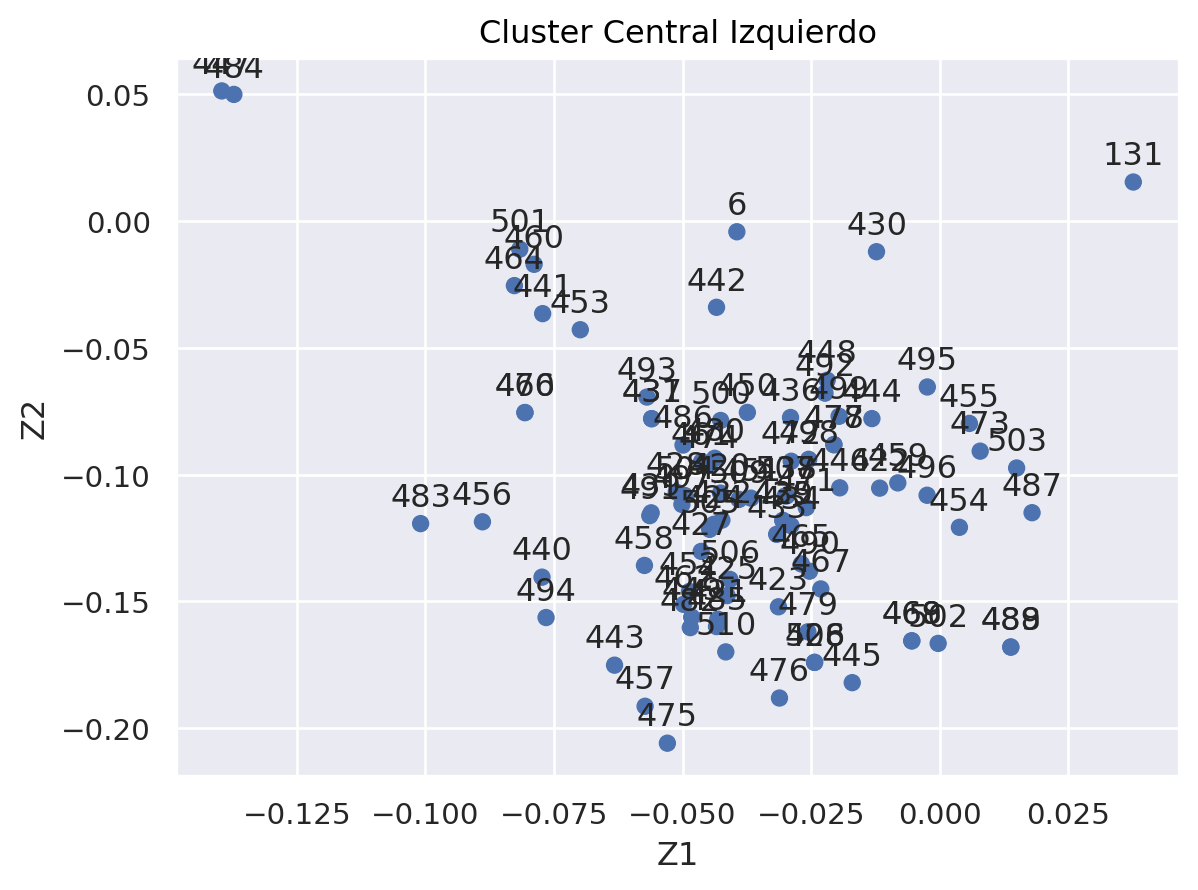

In [21]:
# Cluster Central Izquierdo

ZCentroIzq = Z[(etiquetas4==3)]
(
so.Plot(ZCentroIzq, x="Z1", y="Z2", text=ZCentroIzq.index)
.add(so.Dot())
.add(so.Text(valign="bottom"))
.label(title="Cluster Central Izquierdo")
)

In [22]:
print("Cluster central lado izquierdo")
display(df_sports.iloc[6]["content"])
display(df_sports.iloc[131]["content"])
display(df_sports.iloc[440:441])
display(df_sports.iloc[456]["content"])
display(df_sports.iloc[475:477])
display(df_sports.iloc[493:495])

display(df_sports.iloc[447:448])
display(df_sports.iloc[484:485])

Cluster central lado izquierdo


'Sonia O\'Sullivan will seek to regain her title at the Bupa Great Ireland Run on 9 April in Dublin.\n \n The 35-year-old was beaten into fourth at last year\'s event, having won it a year earlier. "I understand she\'s had a solid winter\'s training down in Australia after recovering from a minor injury," said race director Matthew Turnbull. Mark Carroll, Irish record holder at 3km, 5km and 10km, will make his debut in the mass participation 10km race. Carroll has stepped up his form in recent weeks and in late January scored an impressive 3,000m victory over leading American Alan Webb in Boston. Carroll will be facing stiff competition from Australian Craig Mottram, winner in Dublin for the last two years.\n'

'The Republic of Ireland have arranged friendlies against China and Italy which will take place at Lansdowne Road in March and August.\n \n Brian Kerr\'s side will face the 54th ranked Chinese on 29 March - just three days after the World Cup qualifier against Israel in Tel Aviv. Italy will visit on 17 August in what will be a warm-up game ahead of the autumn World Cup qualifiers. In their last meeting, the Irish beat Italy in the 1994 World Cup Finals. However, that is the Republic\'s only victory in eight attempts against the Italians who have won all the other seven games. The 29 March game will be the second time the Republic have played China - the previous encounter back in June 1984 with the Irish winning 1-0 in Sapporo, Japan. Brian Kerr said: "China have made great progress over the last few years and will provide difficult opposition. "We all witnessed the performances of the Asian teams in the last World Cup, and China play a similar type of football. "As for Italy, they mak

,title,content,category
1753,Serena becomes world number two,Serena Williams has moved up five places to se...,sport


"Mark Philippoussis withdrew from the Sydney International tennis tournament as expected on Sunday after suffering a groin injury during the Hopman Cup.\n \n His participation in the Australian Open, which begins on 17 January in Melbourne, also remains in doubt. Defending women's champion Justine Henin-Hardenne is also out of the Sydney event because of a knee injury. In the only main draw men's or women's singles match on Sunday, Nathalie Dechy beat American Lisa Raymond 7-5 6-3. Number one men's seed Lleyton Hewitt begins his quest for a fourth Sydney title on Tuesday when he plays Karol Beck. Lindsay Davenport, top seed in the women's draw, has been handed a first-round bye and plays France's Dechy in the second round on Tuesday.\n"

,title,content,category
1788,Henman to face Saulnier test,British number one Tim Henman will face France...,sport
1789,Moya suffers shock loss,Fifth seed Carlos Moya was the first big name ...,sport


,title,content,category
1806,Roche 'turns down Federer offer',Australian tennis coach Tony Roche has turned ...,sport
1807,Federer joins all-time greats,The last year has seen one player dominate men...,sport


,title,content,category
1760,Kuznetsova 'failed a drugs test',US Open champion Svetlana Kuznetsova has teste...,sport


,title,content,category
1797,Koubek suspended after drugs test,Stefan Koubek says he has been banned for thre...,sport


Son noticias de Tenis. Nuevamente, las ultimas 2 noticias pueden haber quedado lejos del resto en la Proyeccion por tener palabras relacionadas al escandalo de drogas. De todas formas, fueron correctamente clasificadas el Cluster

## Clasificación

In [23]:
# ej11 pinta ej6
# ej12 pinta ej7

## Clasificación utilizando títulos de las noticias

In [ ]:
# ej14 pinta ej6